In [1]:
import os 
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from xnn.xnn import xNN
from xnn.gamnet import GAMNet
from xnn.sosxnn import SOSxNN

np.set_printoptions(suppress=True, precision = 4)

## Load Data

In [2]:
acc_df = pd.read_csv('../../data/LendingClub/accept2015_2018Q2.csv', index_col = [0])
rej_df = pd.read_csv('../../data/LendingClub/reject2015_2018Q2.csv', index_col  = [0])

acc_df.loc[:,"Purpose"] = acc_df.loc[:,"Purpose"].replace("Credit_Card","1_Credit").replace("Debt_Consolidation",\
                                    "2_Debt").replace("Housing","3_House").replace("Purchase","4_Purchase").replace("Other","5_Other")
cat_features = np.unique(acc_df.loc[:,"Purpose"])
enc = LabelEncoder()
enc.fit(cat_features)
new_cat_features = enc.transform(acc_df.loc[:,"Purpose"])
new_cat_features = new_cat_features.reshape(-1, 1)  
ohe = OneHotEncoder(sparse=False) 
Purpose = ohe.fit_transform(new_cat_features)

acc_df["Purpose1"] = Purpose[:,0]; acc_df["Purpose2"] = Purpose[:,1]; 
acc_df["Purpose3"] = Purpose[:,2]; acc_df["Purpose4"] = Purpose[:,3];  acc_df["Purpose5"] = Purpose[:,4]
acc_df = acc_df.loc[:,['Application_Month', 'Amount_Requested', 'Risk_Score', \
              "Debt_Income_Ratio", "Employment Length", "Purpose1", "Purpose2", "Purpose3", "Purpose4", "Purpose5"]]
acc_df['Label'] = 1

rej_df.loc[:,"Purpose"] = rej_df.loc[:,"Purpose"].replace("Credit_Card","1_Credit").replace("Debt_Consolidation",\
                                    "2_Debt").replace("Housing", "3_House").replace("Purchase","4_Purchase").replace("Other","5_Other")
cat_features = np.unique(rej_df.loc[:,"Purpose"])
enc = LabelEncoder()
enc.fit(cat_features)
new_cat_features = enc.transform(rej_df.loc[:,"Purpose"])
new_cat_features = new_cat_features.reshape(-1, 1)  
ohe = OneHotEncoder(sparse=False) 
Purpose = ohe.fit_transform(new_cat_features)

rej_df["Purpose1"] = Purpose[:,0]; rej_df["Purpose2"] = Purpose[:,1]; 
rej_df["Purpose3"] = Purpose[:,2]; rej_df["Purpose4"] = Purpose[:,3];  rej_df["Purpose5"] = Purpose[:,4]
rej_df = rej_df.loc[:,['Application_Month', 'Amount_Requested', 'Risk_Score', \
              "Debt_Income_Ratio", "Employment Length", "Purpose1", "Purpose2", "Purpose3", "Purpose4", "Purpose5"]]
rej_df['Label'] = 0

data = pd.concat([acc_df, rej_df])
data.loc[data.loc[:,"Debt_Income_Ratio"]>2,:] = np.nan
data.loc[data.loc[:,"Debt_Income_Ratio"]<0,:] = np.nan
data.loc[data.loc[:,"Risk_Score"]>850,:] = np.nan
data = data.dropna()

X = data.iloc[:,:-1].values
Y = data.iloc[:,-1:].values

scaler_x = MinMaxScaler((-1, 1));
sX = scaler_x.fit_transform(X)
sX[:,5:][sX[:,5:]<0] = 0 

train_x, test_x, train_y, test_y = train_test_split(sX, Y, test_size=0.5, random_state=0)

Initial training.
Training epoch: 1, train loss: 0.16252, val loss: 0.16361
Training epoch: 2, train loss: 0.15165, val loss: 0.15298
Training epoch: 3, train loss: 0.14908, val loss: 0.15046
Training epoch: 4, train loss: 0.14892, val loss: 0.15015
Training epoch: 5, train loss: 0.14881, val loss: 0.15008
Training epoch: 6, train loss: 0.14680, val loss: 0.14807
Training epoch: 7, train loss: 0.14566, val loss: 0.14694
Training epoch: 8, train loss: 0.14749, val loss: 0.14887
Training epoch: 9, train loss: 0.14563, val loss: 0.14680
Training epoch: 10, train loss: 0.14625, val loss: 0.14747
Training epoch: 11, train loss: 0.14981, val loss: 0.15129
Training epoch: 12, train loss: 0.14601, val loss: 0.14740
Training epoch: 13, train loss: 0.14728, val loss: 0.14845
Training epoch: 14, train loss: 0.14821, val loss: 0.14958
Training epoch: 15, train loss: 0.14776, val loss: 0.14887
Training epoch: 16, train loss: 0.14607, val loss: 0.14738
Training epoch: 17, train loss: 0.14692, val lo

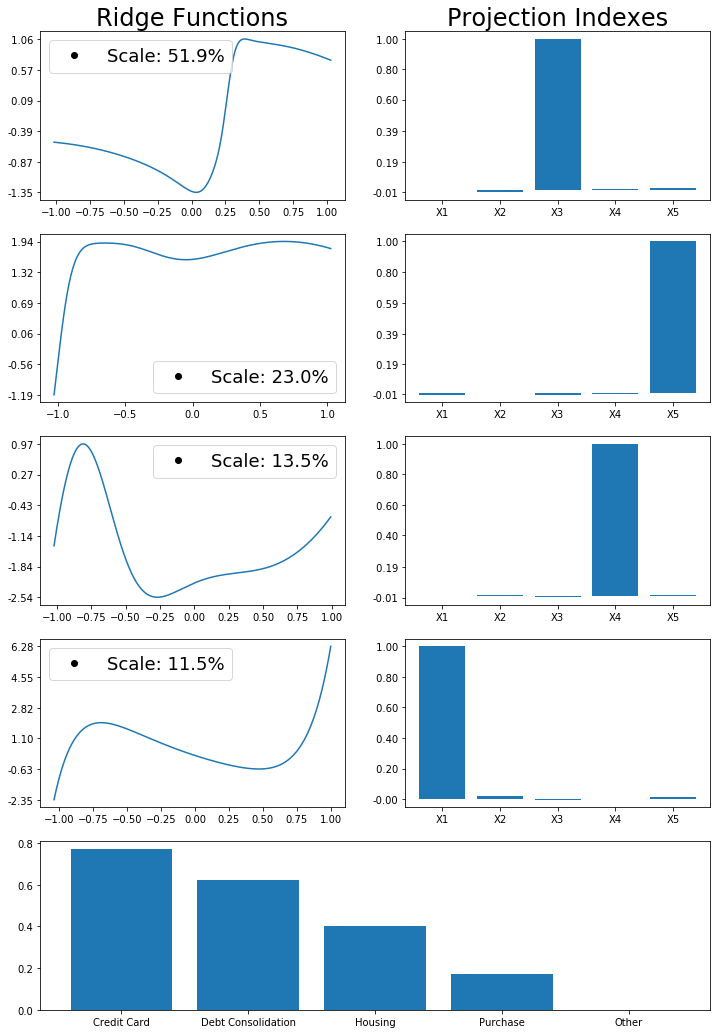

In [17]:
simu_dir = "./results/Lending_Club_test/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

tf.random.set_seed(1)
model = SOSxNN(input_num=5, input_dummy_num=5, subnet_num=5, subnet_arch=[10, 6], task="Classification",
               activation_func=tf.tanh, batch_size=1000, training_epochs=50, lr_bp=0.001, lr_cl=0.1,
               beta_threshold=0.01, tuning_epochs=10, l1_proj=0.1, l1_subnet = 0.01, smooth_lambda=0.00001,
               verbose=True, val_ratio=0.2, early_stop_thres=20)
model.fit(train_x, train_y)
tr_pred = model.predict(model.tr_x) 
val_pred = model.predict(model.val_x) 
pred_test = model.predict(test_x)

model.visualize(simu_dir, "LC_SOSXNN", dummy_name = ['Credit Card', 'Debt Consolidation','Housing', 'Purchase', 'Other'])
print("AUC Score: ", roc_auc_score(test_y, pred_test))

Initial training.
Training epoch: 1, train loss: 0.17009, val loss: 0.17108
Training epoch: 2, train loss: 0.15600, val loss: 0.15739
Training epoch: 3, train loss: 0.15369, val loss: 0.15516
Training epoch: 4, train loss: 0.15314, val loss: 0.15454
Training epoch: 5, train loss: 0.15385, val loss: 0.15529
Training epoch: 6, train loss: 0.15307, val loss: 0.15430
Training epoch: 7, train loss: 0.15026, val loss: 0.15167
Training epoch: 8, train loss: 0.14951, val loss: 0.15090
Training epoch: 9, train loss: 0.15082, val loss: 0.15230
Training epoch: 10, train loss: 0.15368, val loss: 0.15492
Training epoch: 11, train loss: 0.14972, val loss: 0.15105
Training epoch: 12, train loss: 0.15063, val loss: 0.15195
Training epoch: 13, train loss: 0.14811, val loss: 0.14952
Training epoch: 14, train loss: 0.14830, val loss: 0.14968
Training epoch: 15, train loss: 0.14676, val loss: 0.14816
Training epoch: 16, train loss: 0.14964, val loss: 0.15099
Training epoch: 17, train loss: 0.14789, val lo

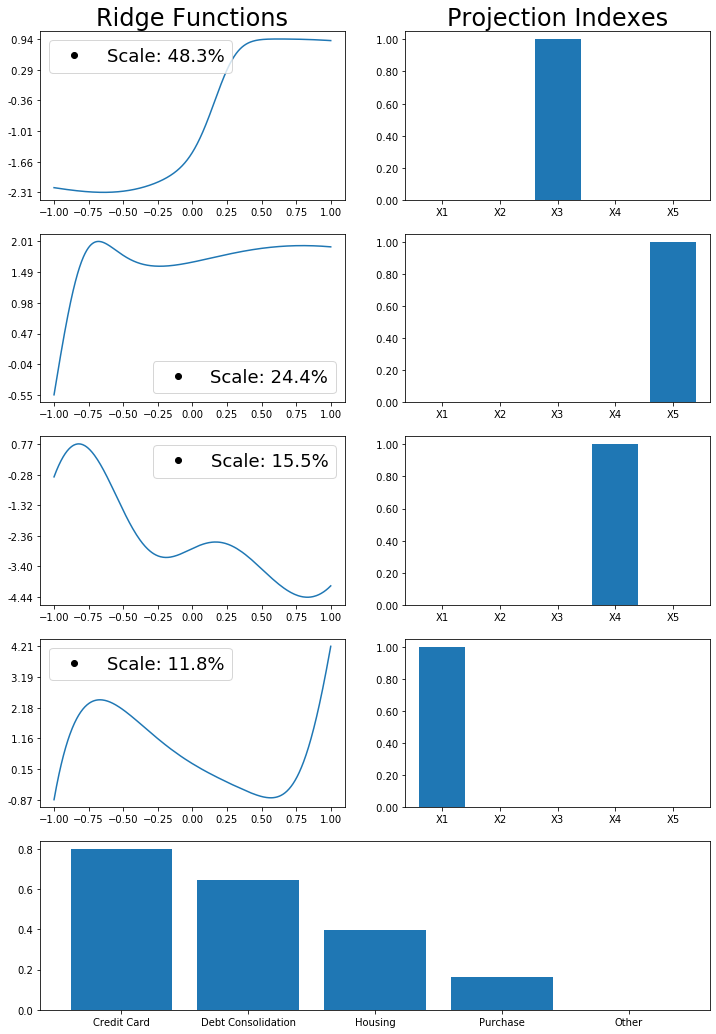

In [4]:
simu_dir = "./results/Lending_Club_test/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

tf.random.set_seed(1)
model = GAMNet(input_num=train_x.shape[1] - 5, input_dummy_num=5, subnet_arch=[10, 6], \
          task="Classification", activation_func=tf.tanh, batch_size=1000, \
          training_epochs=20, beta_threshold=0.01, tuning_epochs=5,  \
          lr_bp=0.001, l1_subnet=0.01, smooth_lambda=10**(-4), 
          verbose=True, val_ratio=0.2, early_stop_thres=5)
model.fit(train_x, train_y); 
tr_pred = model.predict(model.tr_x) 
val_pred = model.predict(model.val_x) 
pred_test = model.predict(test_x)

model.visualize(simu_dir, "LC_SOSXNN", dummy_name = ['Credit Card', 'Debt Consolidation','Housing', 'Purchase', 'Other'])
print("AUC Score: ", roc_auc_score(test_y, pred_test))